## Projeto 2 - FIAD - Data Fusion
- Diogo Fontes 2023187110
- José Silva 2020237724

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, kstest, norm
import statsmodels.api as sm
from scipy.stats import gaussian_kde
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
data = np.loadtxt('Meta2COVID.txt')
df = pd.DataFrame(data, columns=['GD', 'AG', 'MS', 'VA', 'BD', 'HR', 'BP', 'TP', 'Rule'])

df['GUIDELINES'] = 0
df.loc[(df['BD'] >= 2) & (df['TP'] > 37.8),'GUIDELINES'] = 1

a = df[df['Rule'] == 1]
not_a = df[df['Rule'] == 0]

df

,GD,AG,MS,VA,BD,HR,BP,TP,Rule,GUIDELINES
0,0.0,49.148903,1.0,1.0,1.0,83.456271,135.09198,37.503016,0.0,0
1,0.0,84.766807,1.0,0.0,3.0,79.449753,132.81408,36.832310,1.0,0
2,1.0,75.031336,0.0,0.0,3.0,85.470779,137.33184,37.580005,1.0,0
3,1.0,55.087958,0.0,0.0,1.0,51.561135,149.29652,36.959370,0.0,0
4,0.0,62.550938,1.0,0.0,2.0,89.008377,121.42689,37.744883,1.0,0
...,...,...,...,...,...,...,...,...,...,...
595,1.0,68.820531,1.0,0.0,1.0,72.236092,135.37860,36.099066,0.0,0
596,0.0,44.434241,1.0,0.0,1.0,74.460422,144.13974,38.274403,1.0,0
597,0.0,79.903478,0.0,1.0,3.0,43.010392,118.61472,38.173531,0.0,1
598,1.0,63.209868,0.0,0.0,2.0,61.320137,135.02002,37.818543,1.0,1


## Priori
 - O que se sabe antes da observação
calcular as probabilidades a priori diretamente a partir dos dados é uma abordagem mais precisa e baseada em evidências.
Prob_1: Calcula a proporção de instâncias no dataset onde a decisão é stay at hospital (Rule = 1).
Prob_0: Calcula a proporção de instâncias no dataset onde a decisão é return home (Rule = 0).

In [3]:
# Cálculo de probabilidades a priori
Prob_1 = (df['Rule'] == 1).mean()
Prob_0 = (df['Rule'] == 0).mean()

a['P(Rule=1)'] = Prob_1
not_a['P(Rule=0)'] = Prob_0

# Probabilidades a priori
P_return_home = Prob_0
P_stay_at_hospital = Prob_1


C:\Users\2001d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\2001d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
print(f'P(Rule=1)={Prob_1}')
print(f'P(Rule=0)={Prob_0}')

P(Rule=1)=0.32166666666666666
P(Rule=0)=0.6783333333333333


## Variáveis Demográficas (Discrete)
Calcular as verossimilhanças diretamente a partir da frequência dos dados, é uma abordagem válida e muitas vezes preferida, especialmente quando temos variáveis categóricas. Essa abordagem utiliza a distribuição empírica das variáveis no dataset, proporcionando uma modelagem mais direta baseada em dados observados.

In [5]:
Prob_gender_1 = a['GD'].value_counts()/len(a)
Prob_gender_0 = not_a['GD'].value_counts()/len(not_a)

Prob_ms_1 = a['MS'].value_counts()/len(a)
Prob_ms_0 = not_a['MS'].value_counts()/len(not_a)

Prob_va_1 = a['VA'].value_counts()/len(a)
Prob_va_0 = not_a['VA'].value_counts()/len(not_a)

Prob_bd_1 = a['BD'].value_counts()/len(a)
Prob_bd_0 = not_a['BD'].value_counts()/len(not_a)

Prob_guid_1 = a['GUIDELINES'].value_counts()/len(a)
Prob_guid_0 = not_a['GUIDELINES'].value_counts()/len(not_a)

## Likelihood

In [6]:
print(f'P(GD=1|Rule=1)={Prob_gender_1[1]}')
print(f'P(GD=0|Rule=1)={Prob_gender_1[0]}')
print()
print(f'P(GD=1|Rule=0)={Prob_gender_0[1]}')
print(f'P(GD=0|Rule=0)={Prob_gender_0[0]}')

P(GD=1|Rule=1)=0.7202072538860104
P(GD=0|Rule=1)=0.27979274611398963

P(GD=1|Rule=0)=0.43243243243243246
P(GD=0|Rule=0)=0.5675675675675675


In [7]:
print(f'P(MS=1|Rule=1)={Prob_ms_1[1]}')
print(f'P(MS=0|Rule=1)={Prob_ms_1[0]}')
print()
print(f'P(MS=1|Rule=0)={Prob_ms_0[1]}')
print(f'P(MS=0|Rule=0)={Prob_ms_0[0]}')

P(MS=1|Rule=1)=0.5595854922279793
P(MS=0|Rule=1)=0.44041450777202074

P(MS=1|Rule=0)=0.4864864864864865
P(MS=0|Rule=0)=0.5135135135135135


In [8]:
print(f'P(VA=1|Rule=1)={Prob_va_1[1]}')
print(f'P(VA=0|Rule=1)={Prob_va_1[0]}')
print()
print(f'P(VA=1|Rule=0)={Prob_va_0[1]}')
print(f'P(VA=0|Rule=0)={Prob_va_0[0]}')

P(VA=1|Rule=1)=0.20207253886010362
P(VA=0|Rule=1)=0.7979274611398963

P(VA=1|Rule=0)=0.6265356265356266
P(VA=0|Rule=0)=0.37346437346437344


In [9]:
print(f'P(BD=0|Rule=1)={Prob_bd_1[0]}')
print(f'P(BD=1|Rule=1)={Prob_bd_1[1]}')
print(f'P(BD=2|Rule=1)={Prob_bd_1[2]}')
print(f'P(BD=3|Rule=1)={Prob_bd_1[3]}')
print()
print(f'P(BD=0|Rule=0)={Prob_bd_0[0]}')
print(f'P(BD=1|Rule=0)={Prob_bd_0[1]}')
print(f'P(BD=2|Rule=0)={Prob_bd_0[2]}')
print(f'P(BD=3|Rule=0)={Prob_bd_0[3]}')

P(BD=0|Rule=1)=0.15025906735751296
P(BD=1|Rule=1)=0.20207253886010362
P(BD=2|Rule=1)=0.27979274611398963
P(BD=3|Rule=1)=0.36787564766839376

P(BD=0|Rule=0)=0.29975429975429974
P(BD=1|Rule=0)=0.27764127764127766
P(BD=2|Rule=0)=0.22358722358722358
P(BD=3|Rule=0)=0.19901719901719903


In [10]:
print(f'P(GUID=1|Rule=1)={Prob_guid_1[1]}')
print(f'P(GUID=0|Rule=1)={Prob_guid_1[0]}')
print()
print(f'P(GUID=1|Rule=0)={Prob_guid_0[1]}')
print(f'P(GUID=0|Rule=0)={Prob_guid_0[0]}')

P(GUID=1|Rule=1)=0.35233160621761656
P(GUID=0|Rule=1)=0.6476683937823834

P(GUID=1|Rule=0)=0.11793611793611794
P(GUID=0|Rule=0)=0.8820638820638821


## Calcular as Probabilidades a Posteriori

In [11]:
Prob_0_gender = Prob_gender_0*Prob_0
Prob_1_gender = Prob_gender_1*Prob_1

Prob_0_ms = Prob_ms_0*Prob_0
Prob_1_ms = Prob_ms_1*Prob_1

Prob_0_va = Prob_va_0*Prob_0
Prob_1_va = Prob_va_1*Prob_1

Prob_0_bd = Prob_bd_0*Prob_0
Prob_1_bd = Prob_bd_1*Prob_1

Prob_0_guid = Prob_guid_0*Prob_0
Prob_1_guid = Prob_guid_1*Prob_1

In [12]:
# Calcular o likelihood para a classe 1
Prob1_discrete = (Prob_gender_1[df['GD']].to_numpy() *
                  Prob_ms_1[df['MS']].to_numpy() *
                  Prob_va_1[df['VA']].to_numpy() *
                  Prob_bd_1[df['BD']].to_numpy() *
                  Prob_guid_1[df['GUIDELINES']].to_numpy())

df['Prob_Discrete (Rule=1)'] = Prob1_discrete * Prob_1

# Calcular o likelihood para a classe 0
Prob0_discrete = (Prob_gender_0[df['GD']].to_numpy() *
                  Prob_ms_0[df['MS']].to_numpy() *
                  Prob_va_0[df['VA']].to_numpy() *
                  Prob_bd_0[df['BD']].to_numpy() *
                  Prob_guid_0[df['GUIDELINES']].to_numpy())

df['Prob_Discrete (Rule=0)'] = Prob0_discrete * Prob_0


In [13]:

def likelihood_z1(row):
    # Verossimilhança ajustada para GD (Gender)
    gender_likelihood_return_home = Prob_gender_0.get(row['GD'], 0)
    gender_likelihood_stay_at_hospital = Prob_gender_1.get(row['GD'], 0)
    
    # Verossimilhança ajustada para MS (Marital Status)
    marital_status_likelihood_return_home = Prob_ms_0.get(row['MS'], 0)
    marital_status_likelihood_stay_at_hospital = Prob_ms_1.get(row['MS'], 0)
    
    # Verossimilhança ajustada para VA (Vaccinated)
    vaccinated_likelihood_return_home = Prob_va_0.get(row['VA'], 0)
    vaccinated_likelihood_stay_at_hospital = Prob_va_1.get(row['VA'], 0)
    
    # Verossimilhança ajustada para BD (Breathing Difficulty)
    bd_likelihood_return_home = Prob_bd_0.get(row['BD'], 0)
    bd_likelihood_stay_at_hospital = Prob_bd_1.get(row['BD'], 0)
    
    # Verossimilhança ajustada para GUIDELINES
    guidelines_likelihood_return_home = Prob_guid_0.get(row['GUIDELINES'], 0)
    guidelines_likelihood_stay_at_hospital = Prob_guid_1.get(row['GUIDELINES'], 0)
    
    # Combinar todas as verossimilhanças
    likelihood_return_home = (gender_likelihood_return_home * 
                              marital_status_likelihood_return_home * 
                              vaccinated_likelihood_return_home * 
                              bd_likelihood_return_home *
                              guidelines_likelihood_return_home)
                              
    likelihood_stay_at_hospital = (gender_likelihood_stay_at_hospital * 
                                   marital_status_likelihood_stay_at_hospital * 
                                   vaccinated_likelihood_stay_at_hospital * 
                                   bd_likelihood_stay_at_hospital *
                                   guidelines_likelihood_stay_at_hospital)
    
    return likelihood_return_home, likelihood_stay_at_hospital


Probabilidades Condicionais: Estas probabilidades mostram como a decisão (Rule) varia com base nas categorias das variáveis GD (Gender) e MS (Marital Status).
Utilidade: Essas probabilidades são úteis para entender a relação entre as variáveis demográficas e a decisão de permanecer no hospital ou retornar para casa. Elas também são usadas para calcular a verossimilhança combinada (likelihood) na fusão Bayesiana.
Essas probabilidades condicionais são os componentes das verossimilhanças que usamos nas etapas subsequentes para calcular as probabilidades a posteriori e tomar decisões informadas baseadas na fusão Bayesiana.

In [14]:
print(f'P(Rule=1|GD=1)={Prob_1_gender[1]}')
print(f'P(Rule=1|GD=0)={Prob_1_gender[0]}')
print()
print(f'P(Rule=0|GD=1)={Prob_0_gender[1]}')
print(f'P(Rule=0|GD=0)={Prob_0_gender[0]}')

P(Rule=1|GD=1)=0.23166666666666666
P(Rule=1|GD=0)=0.09

P(Rule=0|GD=1)=0.29333333333333333
P(Rule=0|GD=0)=0.385


In [15]:
print(f'P(Rule=1|MS=1)={Prob_1_ms[1]}')
print(f'P(Rule=1|MS=0)={Prob_1_ms[0]}')
print()
print(f'P(Rule=0|MS=1)={Prob_0_ms[1]}')
print(f'P(Rule=0|MS=0)={Prob_0_ms[0]}')

P(Rule=1|MS=1)=0.18
P(Rule=1|MS=0)=0.14166666666666666

P(Rule=0|MS=1)=0.33
P(Rule=0|MS=0)=0.34833333333333333


In [16]:
print(f'P(Rule=1|VA=1)={Prob_1_va[1]}')
print(f'P(Rule=1|VA=0)={Prob_1_va[0]}')
print()
print(f'P(Rule=0|VA=1)={Prob_0_va[1]}')
print(f'P(Rule=0|VA=0)={Prob_0_va[0]}')

P(Rule=1|VA=1)=0.065
P(Rule=1|VA=0)=0.25666666666666665

P(Rule=0|VA=1)=0.42500000000000004
P(Rule=0|VA=0)=0.2533333333333333


In [17]:
print(f'P(Rule=1|BD=0)={Prob_1_bd[0]}')
print(f'P(Rule=1|BD=1)={Prob_1_bd[1]}')
print(f'P(Rule=1|BD=2)={Prob_1_bd[2]}')
print(f'P(Rule=1|BD=3)={Prob_1_bd[3]}')
print()
print(f'P(Rule=0|BD=0)={Prob_0_bd[0]}')
print(f'P(Rule=0|BD=1)={Prob_0_bd[1]}')
print(f'P(Rule=0|BD=2)={Prob_0_bd[2]}')
print(f'P(Rule=0|BD=3)={Prob_0_bd[3]}')

P(Rule=1|BD=0)=0.04833333333333333
P(Rule=1|BD=1)=0.065
P(Rule=1|BD=2)=0.09
P(Rule=1|BD=3)=0.11833333333333332

P(Rule=0|BD=0)=0.2033333333333333
P(Rule=0|BD=1)=0.18833333333333335
P(Rule=0|BD=2)=0.15166666666666667
P(Rule=0|BD=3)=0.135


In [18]:
print(f'P(Rule=1|GUID=1)={Prob_1_guid[1]}')
print(f'P(Rule=1|GUID=0)={Prob_1_guid[0]}')
print()
print(f'P(Rule=0|GUID=1)={Prob_0_guid[1]}')
print(f'P(Rule=0|GUID=0)={Prob_0_guid[0]}')

P(Rule=1|GUID=1)=0.11333333333333333
P(Rule=1|GUID=0)=0.20833333333333331

P(Rule=0|GUID=1)=0.08
P(Rule=0|GUID=0)=0.5983333333333334


## Continuous
A função gaussiana desempenha um papel importante, especialmente quando lidamos com características ou variáveis contínuas que se presume seguirem uma distribuição normal.

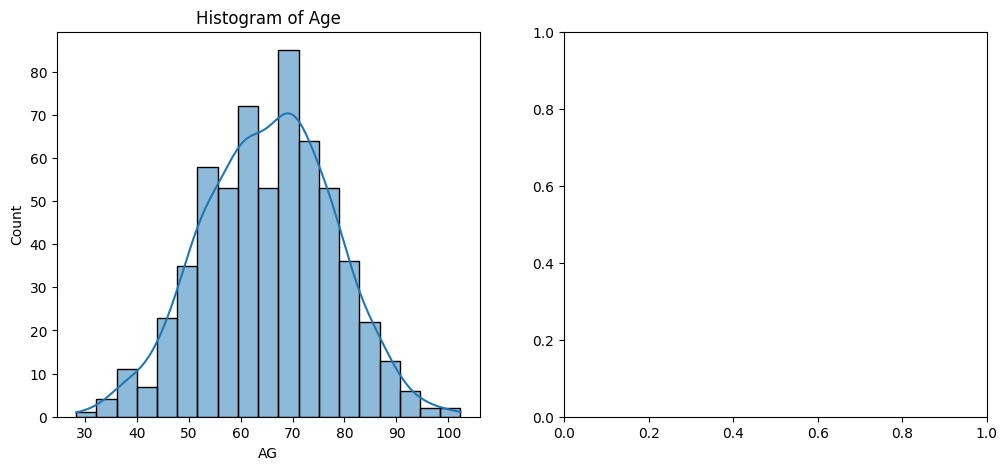

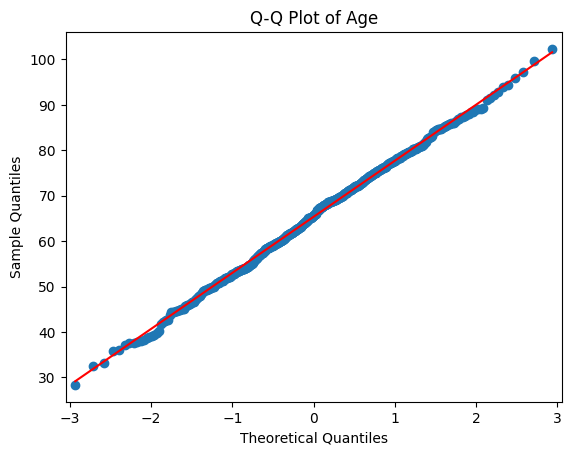

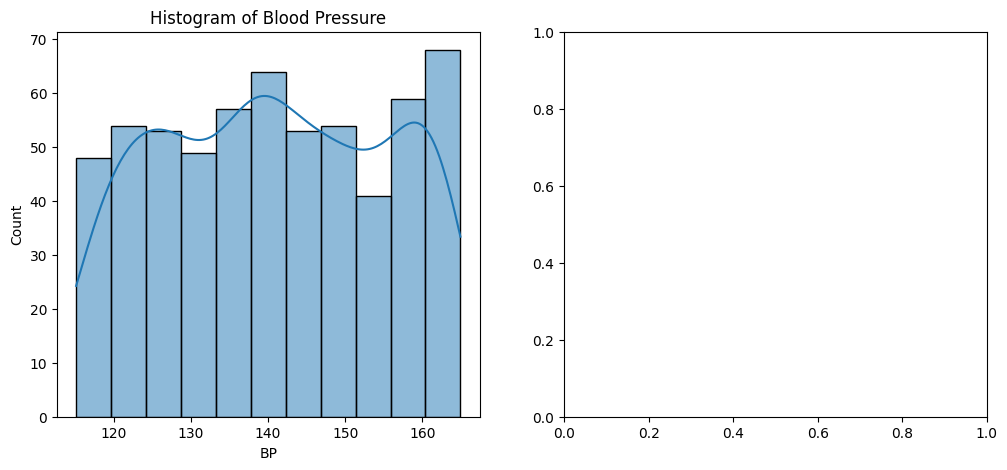

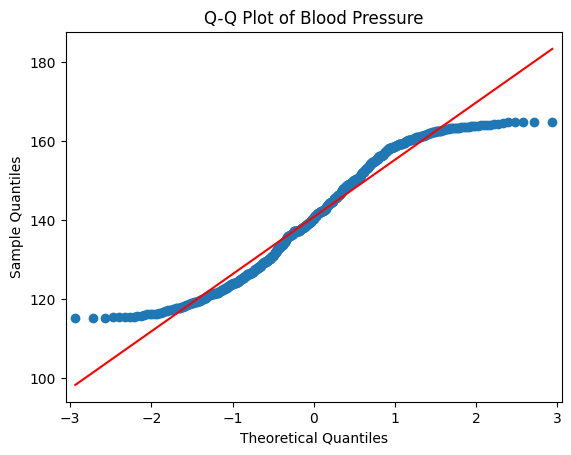

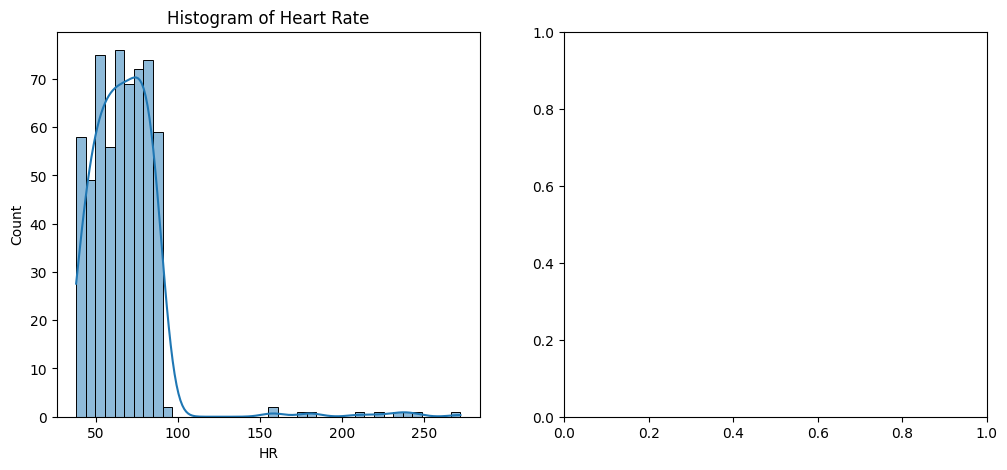

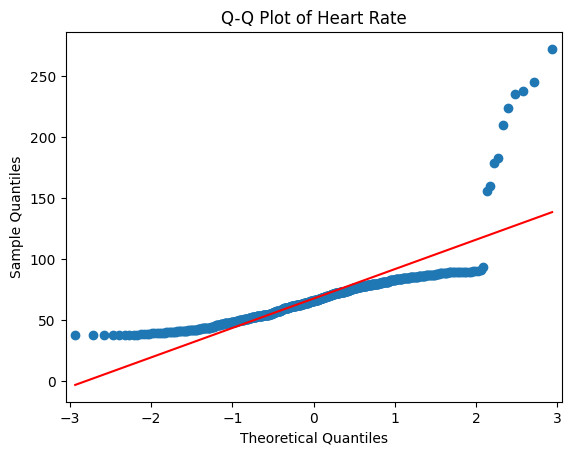

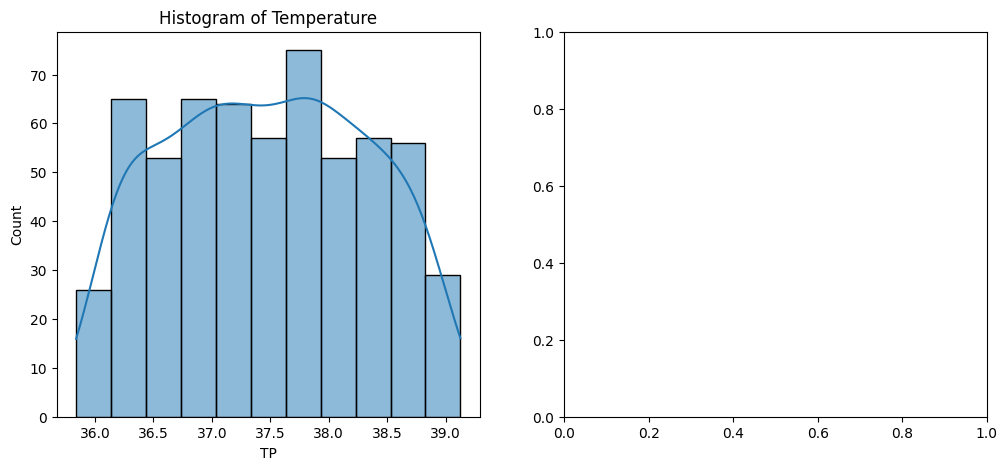

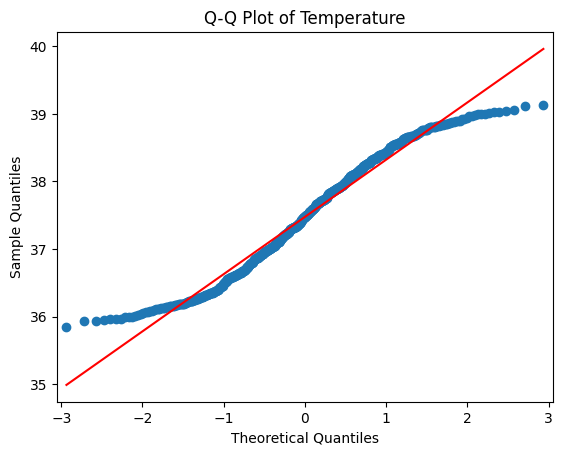

In [19]:
# Função para plotar histogramas e gráficos Q-Q
def plot_histogram_qq(variable, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], kde=True)
    plt.title(f'Histogram of {title}')

    plt.subplot(1, 2, 2)
    sm.qqplot(df[variable], line='s')
    plt.title(f'Q-Q Plot of {title}')

    plt.show()

# Plotar para cada variável contínua
plot_histogram_qq('AG', 'Age')
plot_histogram_qq('BP', 'Blood Pressure')
plot_histogram_qq('HR', 'Heart Rate')
plot_histogram_qq('TP', 'Temperature')


In [20]:
# Função para realizar testes de normalidade
def normality_tests(variable, title):
    stat, p_shapiro = shapiro(df[variable])
    stat, p_ks = kstest(df[variable], 'norm', args=(df[variable].mean(), df[variable].std()))

    print(f'{title} - Shapiro-Wilk Test: p-value={p_shapiro}')
    print(f'{title} - Kolmogorov-Smirnov Test: p-value={p_ks}')

# Testar para cada variável contínua
normality_tests('AG', 'Age')
normality_tests('BP', 'Blood Pressure')
normality_tests('HR', 'Heart Rate')
normality_tests('TP', 'Temperature')


Age - Shapiro-Wilk Test: p-value=0.7590429186820984
Age - Kolmogorov-Smirnov Test: p-value=0.46105280286290384
Blood Pressure - Shapiro-Wilk Test: p-value=7.884203272884305e-13
Blood Pressure - Kolmogorov-Smirnov Test: p-value=0.009669128551437558
Heart Rate - Shapiro-Wilk Test: p-value=3.413189494681786e-32
Heart Rate - Kolmogorov-Smirnov Test: p-value=9.00500419218556e-14
Temperature - Shapiro-Wilk Test: p-value=2.2154440781907425e-10
Temperature - Kolmogorov-Smirnov Test: p-value=0.06037064609727061


## Conclusão Geral
- Idade (Age): Pode ser modelada com uma distribuição Gaussiana.
- Pressão Arterial (Blood Pressure): Não deve ser modelada com uma distribuição Gaussiana.
- Frequência Cardíaca (Heart Rate): Não deve ser modelada com uma distribuição Gaussiana.
- Temperatura (Temperature): Não deve ser modelada com uma distribuição Gaussiana.

## Distribuição Gaussiana para Age


In [21]:
# Estatísticas descritivas para Age (AG)
mean_age_return_home = not_a['AG'].mean()
std_age_return_home = not_a['AG'].std()
mean_age_stay_at_hospital = a['AG'].mean()
std_age_stay_at_hospital = a['AG'].std()

print(f"Mean Age for Return Home: {mean_age_return_home}, Std: {std_age_return_home}")
print(f"Mean Age for Stay at Hospital: {mean_age_stay_at_hospital}, Std: {std_age_stay_at_hospital}")

Mean Age for Return Home: 65.7064469066339, Std: 12.376304195594047
Mean Age for Stay at Hospital: 64.66585355440415, Std: 12.271284945138401


In [22]:
# Função para calcular a verossimilhança baseada na distribuição Gaussiana
def likelihood_age(age):
    likelihood_return_home = norm.pdf(age, mean_age_return_home, std_age_return_home)
    likelihood_stay_at_hospital = norm.pdf(age, mean_age_stay_at_hospital, std_age_stay_at_hospital)
    return likelihood_return_home, likelihood_stay_at_hospital

## Transformações Logarítmicas para as variáveis BD,HR e TP

In [23]:
# Aplicar transformação logarítmica
df['Log_BP'] = np.log(df['BP'])
df['Log_HR'] = np.log(df['HR'])
df['Log_TP'] = np.log(df['TP'])


## Verificar a normalidade depois das Transformações

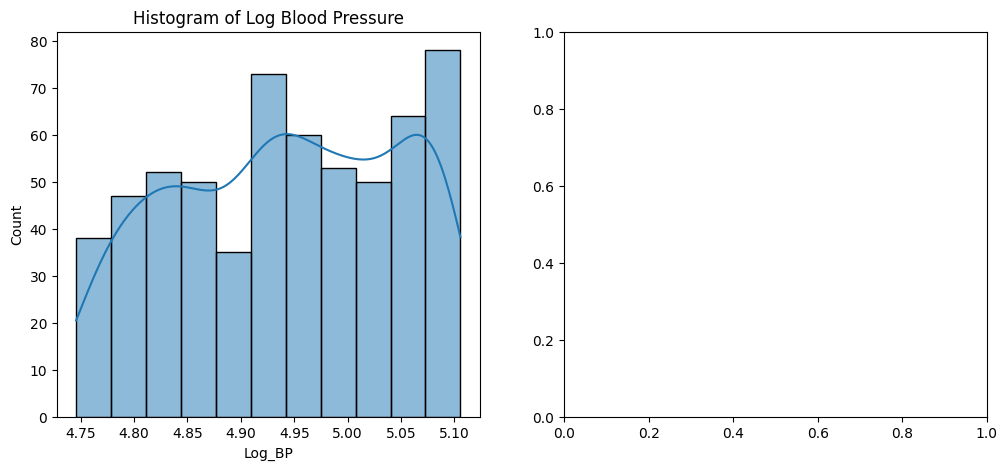

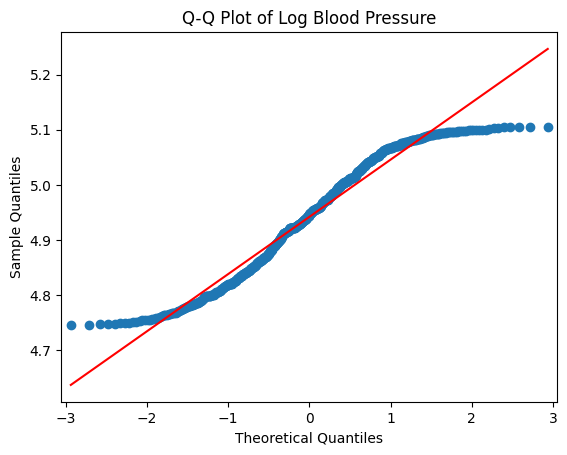

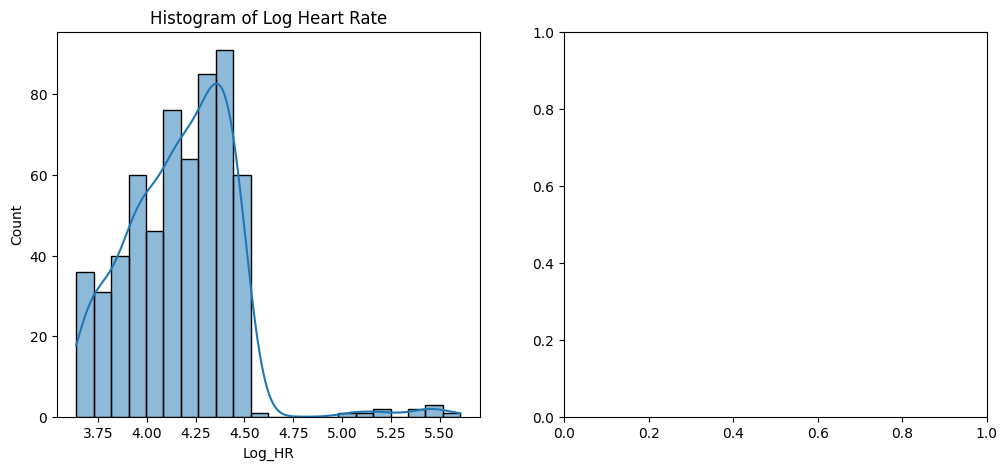

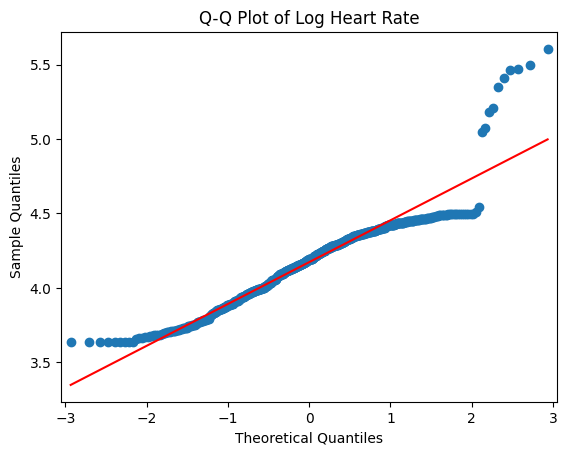

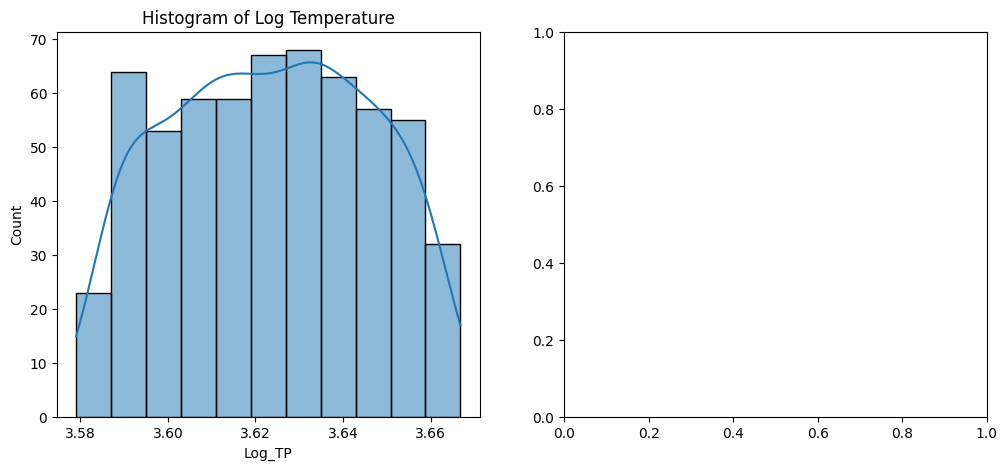

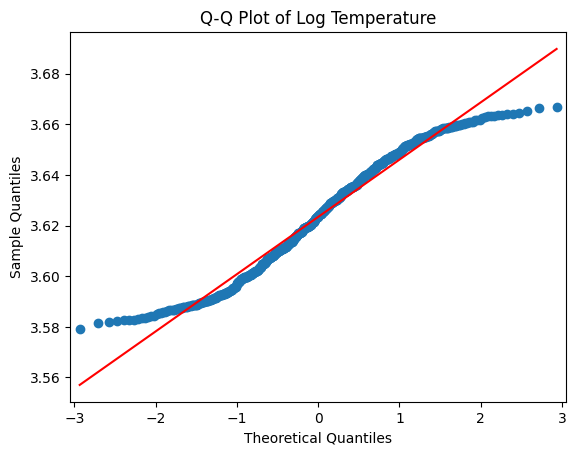

Log Blood Pressure - Shapiro-Wilk Test: p-value=6.236622004419934e-13
Log Blood Pressure - Kolmogorov-Smirnov Test: p-value=0.009835944816567957
Log Heart Rate - Shapiro-Wilk Test: p-value=1.3025842234902204e-17
Log Heart Rate - Kolmogorov-Smirnov Test: p-value=5.311135519115265e-06
Log Temperature - Shapiro-Wilk Test: p-value=2.140831817376565e-10
Log Temperature - Kolmogorov-Smirnov Test: p-value=0.06433193107960133


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro, kstest

# Função para plotar histogramas e gráficos Q-Q
def plot_histogram_qq(variable, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], kde=True)
    plt.title(f'Histogram of {title}')

    plt.subplot(1, 2, 2)
    sm.qqplot(df[variable], line='s')
    plt.title(f'Q-Q Plot of {title}')

    plt.show()

# Plotar para cada variável transformada
plot_histogram_qq('Log_BP', 'Log Blood Pressure')
plot_histogram_qq('Log_HR', 'Log Heart Rate')
plot_histogram_qq('Log_TP', 'Log Temperature')

# Testes de normalidade após transformação
def normality_tests(variable, title):
    stat, p_shapiro = shapiro(df[variable])
    stat, p_ks = kstest(df[variable], 'norm', args=(df[variable].mean(), df[variable].std()))

    print(f'{title} - Shapiro-Wilk Test: p-value={p_shapiro}')
    print(f'{title} - Kolmogorov-Smirnov Test: p-value={p_ks}')

# Testar para cada variável transformada
normality_tests('Log_BP', 'Log Blood Pressure')
normality_tests('Log_HR', 'Log Heart Rate')
normality_tests('Log_TP', 'Log Temperature')


## Conclusão
Dado que as variáveis transformadas ainda não seguem uma distribuição normal, devemos usar métodos não paramétricos para modelar essas variáveis contínuas. Uma abordagem comum é usar a estimativa de densidade de kernel (KDE) para modelar a verossimilhança dessas variáveis.

## Implementar KDE para as variáveis Não Normais

In [25]:
# Dados para KDE
bp_values = df['BP'].values
hr_values = df['HR'].values
tp_values = df['TP'].values

def likelihood_non_parametric(variable, value):
    kde = gaussian_kde(variable)
    return kde.evaluate(value)

In [26]:
# Função geral de verossimilhança para z2 (incluindo Age e variáveis contínuas usando KDE)
def likelihood_z2(row):
    # Verossimilhança para Age (Gaussiana)
    age_likelihood_return_home, age_likelihood_stay_at_hospital = likelihood_age(row['AG'])
    
    # Verossimilhança não paramétrica para Blood Pressure
    bp_likelihood_return_home = likelihood_non_parametric(bp_values, row['BP'])[0]
    bp_likelihood_stay_at_hospital = likelihood_non_parametric(bp_values, row['BP'])[0]
    
    # Verossimilhança não paramétrica para Heart Rate
    hr_likelihood_return_home = likelihood_non_parametric(hr_values, row['HR'])[0]
    hr_likelihood_stay_at_hospital = likelihood_non_parametric(hr_values, row['HR'])[0]
    
    # Verossimilhança não paramétrica para Temperature
    tp_likelihood_return_home = likelihood_non_parametric(tp_values, row['TP'])[0]
    tp_likelihood_stay_at_hospital = likelihood_non_parametric(tp_values, row['TP'])[0]
    
    # Combinar todas as verossimilhanças (multiplicação das verossimilhanças)
    likelihood_return_home = age_likelihood_return_home * bp_likelihood_return_home * hr_likelihood_return_home * tp_likelihood_return_home
    likelihood_stay_at_hospital = age_likelihood_stay_at_hospital * bp_likelihood_stay_at_hospital * hr_likelihood_stay_at_hospital * tp_likelihood_stay_at_hospital
    
    return likelihood_return_home, likelihood_stay_at_hospital

## Posterior 

In [27]:
# Função para calcular a probabilidade a posteriori
def posterior_probabilities(row):
    # Calcular a verossimilhança combinada
    likelihood_return_home, likelihood_stay_at_hospital = likelihood_z2(row)
    
    # Calcular numeradores das probabilidades a posteriori
    posterior_numerator_return_home = likelihood_return_home * P_return_home
    posterior_numerator_stay_at_hospital = likelihood_stay_at_hospital * P_stay_at_hospital
    
    # Calcular o denominador (evidência)
    evidence = posterior_numerator_return_home + posterior_numerator_stay_at_hospital
    
    # Calcular as probabilidades a posteriori
    posterior_return_home = posterior_numerator_return_home / evidence
    posterior_stay_at_hospital = posterior_numerator_stay_at_hospital / evidence
    
    return posterior_return_home, posterior_stay_at_hospital

# Exemplo de aplicação da função de probabilidade a posteriori
row_example = df.iloc[0]  # Exemplo de uma linha do DataFrame
posterior_return_home, posterior_stay_at_hospital = posterior_probabilities(row_example)
print(f"Posterior probability of returning home for the given row: {posterior_return_home}")
print(f"Posterior probability of staying at hospital for the given row: {posterior_stay_at_hospital}")

Posterior probability of returning home for the given row: 0.6552418231522753
Posterior probability of staying at hospital for the given row: 0.3447581768477247


## Combinar as Probabilidades a Posteriori de Z2 com as Verossimilhanças de Z1

In [28]:
# Função para calcular a probabilidade a posteriori combinada
def combined_posterior_probabilities(row):
    # Calcular verossimilhança de Z1
    z1_likelihood_return_home, z1_likelihood_stay_at_hospital = likelihood_z1(row)
    
    # Calcular probabilidade a posteriori de Z2
    z2_posterior_return_home, z2_posterior_stay_at_hospital = posterior_probabilities(row)
    
    # Calcular numeradores das probabilidades a posteriori combinadas
    combined_posterior_return_home = z1_likelihood_return_home * z2_posterior_return_home
    combined_posterior_stay_at_hospital = z1_likelihood_stay_at_hospital * z2_posterior_stay_at_hospital
    
    # Calcular o denominador (evidência)
    evidence = combined_posterior_return_home + combined_posterior_stay_at_hospital
    
    # Calcular as probabilidades a posteriori combinadas
    posterior_return_home = combined_posterior_return_home / evidence
    posterior_stay_at_hospital = combined_posterior_stay_at_hospital / evidence
    
    return posterior_return_home, posterior_stay_at_hospital


## Calcular a Probabilidade a Posteriori Total

In [29]:
# Função para calcular a probabilidade a posteriori total
def posterior_probabilities_total(row):
    z1_likelihood_return_home, z1_likelihood_stay_at_hospital = likelihood_z1(row)
    z2_likelihood_return_home, z2_likelihood_stay_at_hospital = likelihood_z2(row)
    
    posterior_return_home = z1_likelihood_return_home * z2_likelihood_return_home * P_return_home
    posterior_stay_at_hospital = z1_likelihood_stay_at_hospital * z2_likelihood_stay_at_hospital * P_stay_at_hospital
    
    evidence = posterior_return_home + posterior_stay_at_hospital
    
    posterior_return_home /= evidence
    posterior_stay_at_hospital /= evidence
    
    return posterior_return_home, posterior_stay_at_hospital

# Aplicar a função de probabilidade a posteriori total para uma linha do DataFrame
row_example = df.iloc[0]  # Exemplo de uma linha do DataFrame
posterior_return_home, posterior_stay_at_hospital = posterior_probabilities_total(row_example)
print(f"Posterior probability of returning home for the given row: {posterior_return_home}")
print(f"Posterior probability of staying at hospital for the given row: {posterior_stay_at_hospital}")


Posterior probability of returning home for the given row: 0.9510911869097524
Posterior probability of staying at hospital for the given row: 0.048908813090247624


## Tomar Decisões Baseadas nas Probabilidades a Posteriori

In [30]:
# Função para tomar a decisão final baseada nas probabilidades a posteriori totais
def make_final_decision(row):
    posterior_return_home, posterior_stay_at_hospital = posterior_probabilities_total(row)
    return 0 if posterior_return_home > posterior_stay_at_hospital else 1

# Aplicar a função de decisão ao DataFrame
df['Final Decision'] = df.apply(make_final_decision, axis=1)

# Mostrar as primeiras linhas do DataFrame com a decisão final
print(df.head())


    GD         AG   MS   VA   BD         HR         BP         TP  Rule  \
0  0.0  49.148903  1.0  1.0  1.0  83.456271  135.09198  37.503016   0.0   
1  0.0  84.766807  1.0  0.0  3.0  79.449753  132.81408  36.832310   1.0   
2  1.0  75.031336  0.0  0.0  3.0  85.470779  137.33184  37.580005   1.0   
3  1.0  55.087958  0.0  0.0  1.0  51.561135  149.29652  36.959370   0.0   
4  0.0  62.550938  1.0  0.0  2.0  89.008377  121.42689  37.744883   1.0   

   GUIDELINES  Prob_Discrete (Rule=1)  Prob_Discrete (Rule=0)    Log_BP  \
0           0                0.001332                0.028738  4.905956   
1           0                0.009575                0.012279  4.888950   
2           0                0.019397                0.009875  4.922400   
3           0                0.010655                0.013777  5.005934   
4           0                0.007282                0.013795  4.799312   

     Log_HR    Log_TP  Final Decision  
0  4.424323  3.624421               0  
1  4.375125  3.606

In [31]:
df

,GD,AG,MS,VA,BD,HR,BP,TP,Rule,GUIDELINES,Prob_Discrete (Rule=1),Prob_Discrete (Rule=0),Log_BP,Log_HR,Log_TP,Final Decision
0,0.0,49.148903,1.0,1.0,1.0,83.456271,135.09198,37.503016,0.0,0,0.001332,0.028738,4.905956,4.424323,3.624421,0
1,0.0,84.766807,1.0,0.0,3.0,79.449753,132.81408,36.832310,1.0,0,0.009575,0.012279,4.888950,4.375125,3.606375,0
2,1.0,75.031336,0.0,0.0,3.0,85.470779,137.33184,37.580005,1.0,0,0.019397,0.009875,4.922400,4.448175,3.626472,1
3,1.0,55.087958,0.0,0.0,1.0,51.561135,149.29652,36.959370,0.0,0,0.010655,0.013777,5.005934,3.942768,3.609819,0
4,0.0,62.550938,1.0,0.0,2.0,89.008377,121.42689,37.744883,1.0,0,0.007282,0.013795,4.799312,4.488730,3.630850,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1.0,68.820531,1.0,0.0,1.0,72.236092,135.37860,36.099066,0.0,0,0.013538,0.013052,4.908075,4.279940,3.586267,1
596,0.0,44.434241,1.0,0.0,1.0,74.460422,144.13974,38.274403,1.0,0,0.005259,0.017130,4.970783,4.310268,3.644781,0
597,0.0,79.903478,0.0,1.0,3.0,43.010392,118.61472,38.173531,0.0,1,0.001038,0.002907,4.775881,3.761442,3.642142,0
598,1.0,63.209868,0.0,0.0,2.0,61.320137,135.02002,37.818543,1.0,1,0.008026,0.001483,4.905423,4.116108,3.632800,1


## Avaliação com Validação Cruzada

In [32]:
# Definir variáveis para armazenar as métricas de desempenho
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Configurar a validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Realizar a validação cruzada
for train_index, test_index in kf.split(df):
    train_df, test_df = df.iloc[train_index], df.iloc[test_index]
    
    # Aplicar a função de decisão no conjunto de treino
    train_df['Predicted'] = train_df.apply(make_final_decision, axis=1)
    
    # Calcular as métricas de desempenho no conjunto de teste
    y_true = test_df['Rule']
    y_pred = test_df.apply(make_final_decision, axis=1)
    
    accuracies.append(accuracy_score(y_true, y_pred))
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    f1_scores.append(f1_score(y_true, y_pred))

# Calcular e imprimir as médias das métricas de desempenho
print(f"Acurácia média: {np.mean(accuracies):.4f}")
print(f"Precisão média: {np.mean(precisions):.4f}")
print(f"Recall médio: {np.mean(recalls):.4f}")
print(f"F1-score médio: {np.mean(f1_scores):.4f}")


C:\Users\2001d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\2001d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\2001d\A

Acurácia média: 0.8000
Precisão média: 0.7498
Recall médio: 0.5495
F1-score médio: 0.6321


## Conclusões
Conclusões
Desempenho Geral: A acurácia de 80% é promissora, mas não é suficiente para avaliar a eficácia do classificador de forma isolada. A precisão é boa, mas o recall é relativamente baixo, o que reduz o F1-score.

Precisão vs Recall: A diferença significativa entre precisão (75%) e recall (55%) indica que o classificador é mais conservador, preferindo evitar falsos positivos (prever que alguém deve ficar no hospital quando não precisa), mas falha em identificar muitos casos que realmente precisam de atenção (falsos negativos).

Impacto Prático: Em um contexto médico, um recall baixo é preocupante, pois significa que muitos pacientes que realmente precisam ficar no hospital podem ser enviados para casa. Isso pode ter sérias implicações para a saúde dos pacientes.

## Recomendações para Melhorias
Balanceamento do Conjunto de Dados: Verificar se o conjunto de dados está balanceado entre as classes (Rule=0 e Rule=1). Se houver desequilíbrio, técnicas como oversampling, undersampling ou geração de dados sintéticos (SMOTE) podem ajudar.

Ajuste de Parâmetros e Modelos: Experimentar diferentes modelos de machine learning, ajustar hiperparâmetros ou usar técnicas de ensemble (como Random Forests ou Gradient Boosting) pode melhorar a performance.

Feature Engineering: Explorar e criar novas features que possam capturar melhor os padrões nos dados. Analisar a correlação entre as variáveis e a variável alvo pode ajudar a identificar variáveis mais relevantes.

Análise de Erros: Realizar uma análise detalhada dos casos de falsos negativos e falsos positivos para entender onde o classificador está falhando e ajustar o modelo ou os dados de treinamento conforme necessário.

Validação Adicional: Usar outras técnicas de validação, como validação cruzada estratificada, para garantir que o desempenho observado não seja devido a uma divisão específica dos dados.

## Aplicando PCA e remover MS

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Separar as variáveis contínuas e discretas
continuous_vars = ['AG', 'HR', 'BP', 'TP']
discrete_vars = ['GD', 'VA', 'BD', 'GUIDELINES']

# Extrair os dados contínuos e discretos
X_continuous = df[continuous_vars]
X_discrete = df[discrete_vars]

# Normalizar os dados contínuos
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X_continuous)


In [34]:
# Aplicar PCA
pca = PCA(n_components=3)  # Podemos escolher um número adequado de componentes principais
X_pca = pca.fit_transform(X_continuous_scaled)

# Combinar as componentes principais com as variáveis discretas
X_combined = np.hstack((X_pca, X_discrete.values))
y = df['Rule'].values

In [35]:
# Definir variáveis para armazenar as métricas de desempenho
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Configurar a validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Realizar a validação cruzada
for train_index, test_index in kf.split(X_combined):
    X_train, X_test = X_combined[train_index], X_combined[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Treinar um classificador simples (usaremos Random Forest para simplicidade)
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier(random_state=1)
    classifier.fit(X_train, y_train)
    
    # Prever no conjunto de teste
    y_pred = classifier.predict(X_test)
    
    # Calcular as métricas de desempenho no conjunto de teste
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Calcular e imprimir as médias das métricas de desempenho
print(f"Acurácia média: {np.mean(accuracies):.4f}")
print(f"Precisão média: {np.mean(precisions):.4f}")
print(f"Recall médio: {np.mean(recalls):.4f}")
print(f"F1-score médio: {np.mean(f1_scores):.4f}")


Acurácia média: 0.8117
Precisão média: 0.7423
Recall médio: 0.6300
F1-score médio: 0.6769
